# Train new models using new dataset (1500 compounds)

In [33]:
# Autoreload modules
%load_ext autoreload
%autoreload 2

# Add local path
import sys
sys.path.append("/Users/Jphild/Documents/Papers/_***Thesis/MRP7Pred/")

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from pandas import DataFrame
from numpy import ndarray
from typing import Union, Any, Dict, Tuple, List

# Local modules
from src.utils import (
    DATA, 
    OUTPUT,
    ensure_folder,
    get_current_time,
    plot_roc_auc
)
from src.mrp7pred import MRP7Pred
from src.grid import grid
from src.scoring import get_scoring

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 1. Load data and get basic statistics

In [34]:
df = pd.read_csv(f"../data/all_compounds_with_std_smiles.csv", index_col=0)
df.head()

,name,label,std_smiles
0,paclitaxel,1,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...
1,vincristine,1,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...
2,LTC4,1,CCCCCC=CCC=CC=CC=CC(SCC(NC(=O)CCC(N)C(=O)O)C(=...
3,E217bG,1,CC12CCC3c4ccc(O)cc4CCC3C1CCC2OC1OC(C(=O)O)C(O)...
4,gemcitabine,1,Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1


In [35]:
df.reset_index().index

RangeIndex(start=0, stop=1500, step=1)

In [36]:
df = df.rename(columns={"std_smiles" : "smiles"})

Featurzing data ... 

 11%|█         | 163/1500 [00:05<00:40, 33.30it/s]

Error found when processing compound 3,3'-diallyl-5,5'-bis((bis(2-chloroethyl)amino)methyl)[1,1'-biphenyl]-4,4'-diol (ACD/Name)
Smiles: CC1=CC2=[N+]3C1=Cc1cc(C)c4n1[Pd]31n3c(c(C)c(CCC(=O)O)c3=CC3=[N+]1C(=C4)C(C)=C3CCC(=O)O)=C2
ERROR: No Gasteiger Partial Charge parameters for Element: Pd Mode: 


 12%|█▏        | 180/1500 [00:06<00:38, 34.05it/s]

Error found when processing compound MP 317
Smiles: O=C(O[Hg]C[C@@H]1CO[C@@H](C[Hg]OC(=O)c2ccccc2)CO1)c1ccccc1
ERROR: No Gasteiger Partial Charge parameters for Element: Hg Mode: sp


 13%|█▎        | 197/1500 [00:06<00:39, 33.34it/s]

Error found when processing compound Caddy
Smiles: Cl[Cd]Cl
ERROR: No Gasteiger Partial Charge parameters for Element: Cd Mode: sp


 15%|█▍        | 218/1500 [00:07<00:38, 33.14it/s]

Error found when processing compound Purine-6-thiol, chloropalladate(II) deriv., disodium salt, trihydrate
Smiles: Cl[Pd]12([S+]=c3nc[nH]c4[nH]cnc34)([S+]=C3N=CNc4[nH]c[n+]1c43)[S+]=C1N=CNc3[nH]c[n+]2c31
ERROR: No Gasteiger Partial Charge parameters for Element: Pd Mode: 


 19%|█▉        | 283/1500 [00:09<00:38, 32.02it/s]

Error found when processing compound DDP
Smiles: N[Pt](N)(Cl)Cl
ERROR: No Gasteiger Partial Charge parameters for Element: Pt Mode: 


 26%|██▌       | 389/1500 [00:13<00:42, 26.41it/s]

Error found when processing compound N-(4-(((2,4-diamino-6-pteridinyl)methyl)(methyl)amino)-1-naphthoyl)glutamic acid (ACD/Name)
Smiles: CCOC(=O)N1C=CC2=C3C4=C1[Fe]234(C#[O+])(C#[O+])C#[O+]
ERROR: No Gasteiger Partial Charge parameters for Element: Fe Mode: 


 27%|██▋       | 404/1500 [00:14<00:35, 30.92it/s]

Error found when processing compound SG
Smiles: CC[Ge]1(CC)CCC2(CCN(CCCN(C)C)C2)CC1
ERROR: No Gasteiger Partial Charge parameters for Element: Ge Mode: sp3


 28%|██▊       | 425/1500 [00:15<00:36, 29.55it/s]

Error found when processing compound PALA
Smiles: O=C(O)C[C@@H](NC(=O)CP(=O)(O)O)C(=O)O.[NaH]
ERROR: No Gasteiger Partial Charge parameters for Element: Na Mode: 


 29%|██▉       | 433/1500 [00:15<00:41, 26.00it/s]

Error found when processing compound CBDCA
Smiles: N[Pt]1(N)OC(=O)C2(CCC2)C(=O)O1
ERROR: No Gasteiger Partial Charge parameters for Element: Pt Mode: 


 30%|██▉       | 448/1500 [00:16<00:36, 29.10it/s]

Error found when processing compound CHIP
Smiles: CC(C)N[Pt](O)(O)(Cl)(Cl)NC(C)C
ERROR: No Gasteiger Partial Charge parameters for Element: Pt Mode: 


 32%|███▏      | 477/1500 [00:17<00:36, 28.24it/s]

Error found when processing compound Platinate(1-), (1,2,4-benzenetricarboxylato(3-)-O1,O2)(1, 2-cyclohexanediamine-N,N')-, hydrogen, (SP-4-3)-
Smiles: O=C(O)c1ccc2c(c1)C(=O)O[Pt]1(N[C@H]3CCCC[C@@H]3N1)OC2=O
ERROR: No Gasteiger Partial Charge parameters for Element: Pt Mode: 


 41%|████      | 617/1500 [00:21<00:28, 31.10it/s]

Error found when processing compound Tetraplatin
Smiles: Cl[Pt]1(Cl)(Cl)(Cl)N[C@@H]2CCCC[C@H]2N1
ERROR: No Gasteiger Partial Charge parameters for Element: Pt Mode: 


 46%|████▋     | 696/1500 [00:24<00:26, 30.26it/s]

Error found when processing compound Camptothecin hemisuccinate sodium salt
Smiles: CC[C@]1(OC(=O)CCC(=O)O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3ccccc3nc2-1.[NaH]
ERROR: No Gasteiger Partial Charge parameters for Element: Na Mode: 


 47%|████▋     | 707/1500 [00:24<00:33, 23.85it/s]

Error found when processing compound Benzoic acid, 2-hydroxy-, (2,6-pyridinediyldiethylidyne) dihydrazide, nickel complex
Smiles: CC1=[N+]2[N-]C(c3ccccc3O)=[O+][Ni+]234(Cl)[O+]=C(c2ccccc2O)[N-][N+]3=C(C)c2cccc1[n+]24.[Cl-]
ERROR: No Gasteiger Partial Charge parameters for Element: Ni Mode: 


 49%|████▉     | 735/1500 [00:25<00:24, 30.98it/s]

Error found when processing compound bis((mercapto(4-morpholinyl)methylene)-lambda~4~-sulfanyl)copper (ACD/Name)
Smiles: C1CN(C2=[S+][Cu+2]3([S+]=C(N4CCOCC4)[SH+]3)[SH+]2)CCO1
ERROR: No Gasteiger Partial Charge parameters for Element: Cu Mode: 
Error found when processing compound bis((mercapto(4-methyl-1-piperazinyl)methylene)-lambda~4~-sulfanyl)copper (ACD/Name)
Smiles: CN1CCN(C2=[S+][Cu+2]3([S+]=C(N4CCN(C)CC4)[SH+]3)[SH+]2)CC1
ERROR: No Gasteiger Partial Charge parameters for Element: Cu Mode: 


 51%|█████     | 763/1500 [00:26<00:25, 29.35it/s]

Error found when processing compound Mercury, {chloro[[4-(1,1-dimethylethyl)-1-} nitrocyclohexyl\]methyl\]-
Smiles: CC(C)(C)[C@H]1CC[C@]([CH-][Hg+]Cl)([N+](=O)[O-])CC1
ERROR: No Gasteiger Partial Charge parameters for Element: Hg Mode: sp3


 52%|█████▏    | 786/1500 [00:27<00:19, 36.08it/s]

Error found when processing compound Bismuth, dichloro(1-piperidinylcarbamodithioato-S,S')-, (T-4)-
Smiles: Cl[Bi+]1(Cl)[S+]=C(N2CCCCC2)[SH+]1
ERROR: No Gasteiger Partial Charge parameters for Element: Bi Mode: sp3
Error found when processing compound 1-Piperidinecarbodithioic acid, antimony complex
Smiles: Br[Sb+]1(Br)[S+]=C(N2CCCCC2)[SH+]1
ERROR: No Gasteiger Partial Charge parameters for Element: Sb Mode: sp3
Error found when processing compound 4-Thiomorpholinecarbodithioic acid, antimony complex
Smiles: Br[Sb+]1(Br)[S+]=C(N2CCSCC2)[SH+]1
ERROR: No Gasteiger Partial Charge parameters for Element: Sb Mode: sp3
Error found when processing compound Thiomorpholinecarbodithioic acid, (iododiiodo)antimonycomplex
Smiles: I[Sb+2]12([S+]=C(N3CCSCC3)[SH+]1)[S+]=C(N1CCSCC1)[SH+][SbH+]1(I)([S+]=C(N3CCSCC3)[SH+]1)[I]2
ERROR: No Gasteiger Partial Charge parameters for Element: Sb Mode: sp3
Error found when processing compound 1-Piperidinecarbodithioic acid, antimony complex
Smiles: Cl[Sb+2]12([S

 54%|█████▎    | 805/1500 [00:27<00:20, 34.13it/s]

Error found when processing compound 2,1,3-Benzoselanadiazole, nitro-6-(trifluoromethyl)-
Smiles: O=[N+]([O-])c1cc(C(F)(F)F)cc2n[se]nc12
ERROR: No Gasteiger Partial Charge parameters for Element: Se Mode: sp2


 55%|█████▍    | 820/1500 [00:28<00:21, 31.65it/s]

Error found when processing compound 4H-1,3,2-Benzodioxastannin-4-one, 7-amino-2,2-dibutyl-
Smiles: CCCC[Sn]1(CCCC)OC(=O)c2ccc(N)cc2O1
ERROR: No Gasteiger Partial Charge parameters for Element: Sn Mode: sp3
Error found when processing compound 4H-1,3,2-Benzodioxastannin-4-one, 7-amino-2,2-diphenyl-
Smiles: Nc1ccc2c(c1)O[Sn](c1ccccc1)(c1ccccc1)OC2=O
ERROR: No Gasteiger Partial Charge parameters for Element: Sn Mode: sp3
Error found when processing compound ethylene compound with 8-(((8-quinolinyloxy)-lambda~2~-stannanyl)oxy)quinoline (2:1) (ACD/Name)
Smiles: C=C[Sn](C=C)(Oc1cccc2cccnc12)Oc1cccc2cccnc12
ERROR: No Gasteiger Partial Charge parameters for Element: Sn Mode: sp3


 56%|█████▌    | 833/1500 [00:28<00:19, 33.43it/s]

Error found when processing compound Trichlorotris-3-(t-butyl)pyrazoleruthenium(III)
Smiles: CC(C)(C)c1cc[n+]([Ru](Cl)(Cl)(Cl)([n+]2ccc(C(C)(C)C)[n-]2)[n+]2ccc(C(C)(C)C)[n-]2)[n-]1
ERROR: No Gasteiger Partial Charge parameters for Element: Ru Mode: 


 56%|█████▌    | 838/1500 [00:28<00:20, 32.21it/s]

Error found when processing compound cis-Dichlorobis(4-methoxyphenethylamine)platinum(II)
Smiles: COc1ccc(CCN[Pt](Cl)(Cl)NCCc2ccc(OC)cc2)cc1
ERROR: No Gasteiger Partial Charge parameters for Element: Pt Mode: 
Error found when processing compound cis-Amminedichloro(4-methoxyphenethylamine)platinum(II)
Smiles: COc1ccc(CCN[Pt](N)(Cl)Cl)cc1
ERROR: No Gasteiger Partial Charge parameters for Element: Pt Mode: 


 57%|█████▋    | 853/1500 [00:29<00:19, 33.74it/s]

Error found when processing compound Platinum, {dichloro(quinoline-N)[sulfinylbis(methane)-S]-,} (SP-4-1)
Smiles: C[S](C)(=O)[Pt](Cl)(Cl)[n+]1cccc2ccccc21
ERROR: No Gasteiger Partial Charge parameters for Element: Pt Mode: 
Error found when processing compound Platinum, {dichloro[(methylsulfinyl)phenyl-S](quinoline-N)-,} (SP-4-1)
Smiles: C[S@@](=O)(c1ccccc1)[Pt](Cl)(Cl)[n+]1cccc2ccccc21
ERROR: No Gasteiger Partial Charge parameters for Element: Pt Mode: 
Error found when processing compound Tetrakisoxinatosilicon(IV)tetrahydrochloride
Smiles: [Cl-].c1cnc2c([OH+][Si]34([OH+]c5cccc6cccnc56)([OH+]c5cccc6ccc[n+]3c56)[OH+]c3cccc5ccc[n+]4c35)cccc2c1
ERROR: No Gasteiger Partial Charge parameters for Element: Si Mode: 


 57%|█████▋    | 861/1500 [00:29<00:19, 32.37it/s]

Error found when processing compound Chlorobis(4-isopropyltropolonato)bismuth(III)
Smiles: CC(C)C1=CC=CC2=[O+][Bi+2]3(Cl)([O+]=C4C=CC=C(C(C)C)C=C4[OH+]3)[OH+]C2=C1
ERROR: No Gasteiger Partial Charge parameters for Element: Bi Mode: sp3


 58%|█████▊    | 875/1500 [00:30<00:21, 28.85it/s]

Error found when processing compound Copper, {bromo[2-[1-(2-pyridinyl)ethylidene][N,} N-dimethyl-hydrazinecarbothioamidato-N,N,S\]-
Smiles: CC1=[N+]2[N-]C(N(C)C)=[S+][Cu+]2(Br)[n+]2ccccc21
ERROR: No Gasteiger Partial Charge parameters for Element: Cu Mode: 
Error found when processing compound Diethoxybis(2-acetyl-1-hydrindonato)titanium(IV)
Smiles: CC[OH+][Ti]12([OH+]CC)([O+]=C3C(=C(C)[OH+]1)Cc1ccccc13)[O+]=C1C(=C(C)[OH+]2)Cc2ccccc21
ERROR: No Gasteiger Partial Charge parameters for Element: Ti Mode: 


 60%|█████▉    | 896/1500 [00:30<00:19, 30.62it/s]

Error found when processing compound 2-N-Methyl-6-thiaellipticinum iodide
Smiles: COc1cccc2c1[OH+][Cu@@+2]1([O-])[S+]=C(N)[N-][N+]1=C2
ERROR: No Gasteiger Partial Charge parameters for Element: Cu Mode: 
Error found when processing compound Hydrazinecarbothioamide, {2-[(2-hydroxy-3-methoxyphenyl)-methylene]-,} 1,10-phenanthroline aqua copper complex
Smiles: COc1cccc2c1[OH+][Cu+2]13([O-])([S+]=C(N)[N-][N+]1=C2)[n+]1cccc2ccc4ccc[n+]3c4c21
ERROR: No Gasteiger Partial Charge parameters for Element: Cu Mode: 


 61%|██████    | 909/1500 [00:31<00:17, 33.01it/s]

Error found when processing compound Chlorotris(chinoline-8-olato)titanium(IV)-trihydrochloride
Smiles: [Cl-].[ClH+][Ti]12([OH+]c3cccc4cccnc34)([OH+]c3cccc4ccc[n+]1c34)[OH+]c1cccc3ccc[n+]2c13
ERROR: No Gasteiger Partial Charge parameters for Element: Ti Mode: 
Error found when processing compound Tetrakis(8-chinolineolato)titanium(IV)-tetrahydrochloride
Smiles: [Cl-].c1cnc2c([OH+][Ti]([OH+]c3cccc4cccnc34)([OH+]c3cccc4cccnc34)[OH+]c3cccc4cccnc34)cccc2c1
ERROR: No Gasteiger Partial Charge parameters for Element: Ti Mode: sp3


 64%|██████▎   | 954/1500 [00:32<00:17, 31.72it/s]

Error found when processing compound 5-(4-hydroxy-3,5-dimethoxyphenyl)-5,6,11,11a-tetrahydro-1H-[1,3]oxazolo[4',3':6,1]pyrido[3,4-b]indol-3-one (ACD/Name)
Smiles: C[S@@](=O)(Cc1ccccc1)[Pt](Cl)(Cl)[n+]1cccc2ccccc21
ERROR: No Gasteiger Partial Charge parameters for Element: Pt Mode: 


 64%|██████▍   | 964/1500 [00:33<00:15, 33.95it/s]

Error found when processing compound (4-(((2-(4-(carboxymethoxy)-2,3-dichlorophenyl)-1-(5-(2-methylphenyl)-3H-1,2-dithiol-3-ylidene)-2-oxoethyl)dithio)(5-(2-methylphenyl)-3H-1,2-dithiol-3-ylidene)acetyl)-2,3-dichlorophenoxy)acetic acid (ACD/Name)
Smiles: CCCN(CCC)C1=[S+][Cu+]2(Cl)[N+](=Cc3cccc[n+]32)[N-]1
ERROR: No Gasteiger Partial Charge parameters for Element: Cu Mode: 
Error found when processing compound (4-(((2-(4-(carboxymethoxy)-2,3-dichlorophenyl)-1-(5-(2-methylphenyl)-3H-1,2-dithiol-3-ylidene)-2-oxoethyl)dithio)(5-(2-methylphenyl)-3H-1,2-dithiol-3-ylidene)acetyl)-2,3-dichlorophenoxy)acetic acid (ACD/Name)
Smiles: CC1=[N+]2[N-]C(N3CCCCCC3)=[S+][Cu+]2(Cl)[n+]2ccncc21
ERROR: No Gasteiger Partial Charge parameters for Element: Cu Mode: 


 67%|██████▋   | 1000/1500 [00:33<00:12, 39.58it/s]

Error found when processing compound 1,2-Benzo-8-(D,L-alanyl)-3-phenoxazone
Smiles: COc1ccc(/C=C/c2cc(OC)c(OC)c(OC)c2)cc1OCC(=O)O.[NaH]
ERROR: No Gasteiger Partial Charge parameters for Element: Na Mode: 
Error found when processing compound 1,1,3,3-tetrabutyl-1,3-bis((2,3,4-trimethoxybenzoyl)oxy)distannoxane (ACD/Name)
Smiles: CCCC[Sn](CCCC)(OC(=O)c1ccc(OC)c(OC)c1OC)O[Sn](CCCC)(CCCC)OC(=O)c1ccc(OC)c(OC)c1OC
ERROR: No Gasteiger Partial Charge parameters for Element: Sn Mode: sp3
Error found when processing compound 1,1,3,3-tetrabutyl-1,3-bis((2,3-difluorobenzoyl)oxy)distannoxane (ACD/Name)
Smiles: CCCC[Sn](CCCC)(OC(=O)c1cccc(F)c1F)O[Sn](CCCC)(CCCC)OC(=O)c1cccc(F)c1F
ERROR: No Gasteiger Partial Charge parameters for Element: Sn Mode: sp3
Error found when processing compound 1,1,3,3-tetrabutyl-1,3-bis((2,5-difluorobenzoyl)oxy)distannoxane (ACD/Name)
Smiles: CCCC[Sn](CCCC)(OC(=O)c1cc(F)ccc1F)O[Sn](CCCC)(CCCC)OC(=O)c1cc(F)ccc1F
ERROR: No Gasteiger Partial Charge parameters for Element: Sn 

 67%|██████▋   | 1010/1500 [00:34<00:14, 34.84it/s]

Error found when processing compound Bisacetylacetone ethylenediimine tin
Smiles: CC1=[O+][Sn+2]23(N=CC=N2)([O+]=C(C)[CH-]1)[O+]=C(C)[CH-]C(C)=[O+]3
ERROR: No Gasteiger Partial Charge parameters for Element: Sn Mode: sp3


 69%|██████▊   | 1031/1500 [00:34<00:12, 37.29it/s]

Error found when processing compound {[Bis(aminomethyl)diethylsilane]dichloroplatinum} (II)
Smiles: CC[Si]1(CC)CN[Pt](Cl)(Cl)NC1
ERROR: No Gasteiger Partial Charge parameters for Element: Pt Mode: 
Error found when processing compound {[Bis(aminomethyl)cyclobutamethylenesilane]dichloroplatinum} (II)
Smiles: Cl[Pt]1(Cl)NC[Si]2(CCCC2)CN1
ERROR: No Gasteiger Partial Charge parameters for Element: Pt Mode: 
Error found when processing compound {[Bis(aminomethyl)cyclopentamethylenesilane]dichloroplatinum} (II)
Smiles: Cl[Pt]1(Cl)NC[Si]2(CCCCC2)CN1
ERROR: No Gasteiger Partial Charge parameters for Element: Pt Mode: 
Error found when processing compound 2-oxo-1-phenyl-2-(lambda~2~-stannanyloxy)ethanol compound with methane (1:3) (ACD/Name)
Smiles: C[Sn](C)(C)OC(=O)[C@H](O)c1ccccc1
ERROR: No Gasteiger Partial Charge parameters for Element: Sn Mode: sp3
Error found when processing compound 2-methoxy-5-(2-(3,4,5-trimethoxyphenyl)vinyl)phenyl dihydrogen phosphate ammoniate (ACD/Name)
Smiles: COc1

 71%|███████   | 1065/1500 [00:35<00:11, 36.45it/s]

Error found when processing compound (2-((1-(diethoxymethyl)propyl)seleno)phenyl)(hydroxy)azane oxide (ACD/Name)
Smiles: CCOC(OCC)[C@@H](CC)[Se]c1ccccc1[N+](=O)[O-]
ERROR: No Gasteiger Partial Charge parameters for Element: Se Mode: sp3
Error found when processing compound Rhodium dimer
Smiles: Cl[Rh+]12(Cl)([n+]3ccc(-c4ccccc4)c4ccc5c(-c6ccccc6)cc[n+]1c5c43)[n+]1ccc(-c3ccccc3)c3ccc4c(-c5ccccc5)cc[n+]2c4c31.[Cl-]
ERROR: No Gasteiger Partial Charge parameters for Element: Rh Mode: 


 74%|███████▍  | 1115/1500 [00:37<00:10, 36.00it/s]

Error found when processing compound (5-(5-(5-(hydroxymethyl)-2-thienyl)-2-furyl)-2-thienyl)methanol (ACD/Name)
Smiles: c1ccc([PH]([Au+][n+]2cc[n-]c2)(c2ccccc2)c2ccccc2)cc1
ERROR: No Gasteiger Partial Charge parameters for Element: P Mode: 
Error found when processing compound (5-(5-(5-(hydroxymethyl)-2-thienyl)-2-furyl)-2-thienyl)methanol (ACD/Name)
Smiles: c1ccc(Cn2cc[n+]3c2[Au][n+]2ccn(Cc4ccccc4)c2[Au][n+]2ccn(Cc4ccccc4)c2[Au]3)cc1
ERROR: No Gasteiger Partial Charge parameters for Element: Au Mode: 


 75%|███████▌  | 1132/1500 [00:37<00:10, 34.96it/s]

Error found when processing compound N,N-Dimethylglycylaminophenylbenzoylurea (HCl salt)
Smiles: CCCNC1=[S+][Cu]2(Cl)(Cl)[N+](=C(C)c3cccc[n+]32)[N-]1
ERROR: No Gasteiger Partial Charge parameters for Element: Cu Mode: 


 82%|████████▏ | 1236/1500 [00:41<00:08, 31.91it/s]

Error found when processing compound diphenyl(4-(phenyl(triphenylphosphoranylidene)methyl)phenyl)phosphine selenide (ACD/Name)
Smiles: [Se]=P(c1ccccc1)(c1ccccc1)c1ccc(C(c2ccccc2)=P(c2ccccc2)(c2ccccc2)c2ccccc2)cc1
ERROR: No Gasteiger Partial Charge parameters for Element: Se Mode: sp2


 91%|█████████ | 1365/1500 [00:45<00:04, 32.19it/s]

Error found when processing compound 3,4-di(1H-indol-3-yl)-1-methyl-2,5-pyrrolidinedione (ACD/Name)
Smiles: CC(C)(C)C#CI1OC(=O)c2ccccc21
ERROR: No Gasteiger Partial Charge parameters for Element: I Mode: 


 95%|█████████▍| 1422/1500 [00:47<00:02, 33.48it/s]

Error found when processing compound 2-(6,11-dioxo-6,11-dihydrobenzo[b]acridin-12-yl)acrylaldehyde (ACD/Name)
Smiles: Cc1cc[n+]([Pt+2]23[n+]4ccccc4-c4cccc([n+]42)-c2cccc[n+]23)cc1.F[B-](F)(F)F
ERROR: No Gasteiger Partial Charge parameters for Element: Pt Mode: 


100%|██████████| 1500/1500 [00:49<00:00, 30.28it/s]

Dropped 64 unfeaturizable compounds.
Done!
Spliting training and test data ... 

Done!
Start training ...Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   33.6s finished


Best score: 0.9015682551737232
Done!
Best model:
Pipeline(steps=[('sclr', DummyScaler(scaler=StandardScaler())),
                ('clf', SVC(C=1000, gamma=0.0001, probability=True))])
Evaluate model on test data ... Done! Score: 0.8854166666666666
Getting full score set ... Done! Full scores: {'stats': {'tp': 0.0, 'fp': 2.0, 'tn': 255.0, 'fn': 31.0}, 'score': {'roc_auc': 0.6644910254801054, 'accuracy': 0.8854166666666666}}
Plotting ROC for test data ... 

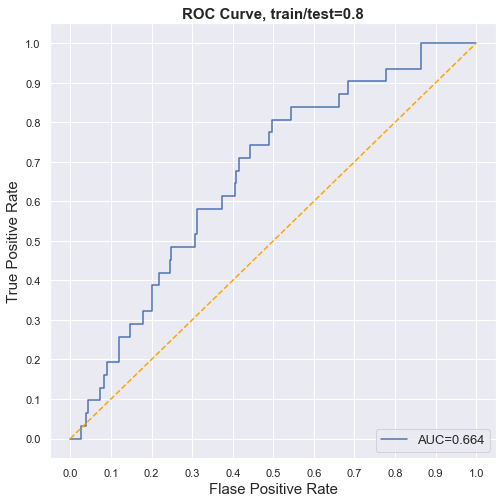

Done!


In [37]:
m7p = MRP7Pred(train_new=True)
m7p.run_train(df, train_test_ratio=0.8, grid=grid)